In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9086
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  F7UPK8AX_05_51_31
NN-MODEL FILENAME:  ./models/F7UPK8AX_05_51_31_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 1
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  1


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 11981.43 MiB, increment: 10862.94 MiB
Quantization TIME:  0.1 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   13289
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 46
TOTAL SERIAL TIMESTEPS:   13289
TOTAL PARALLEL TIMESTEPS: 46


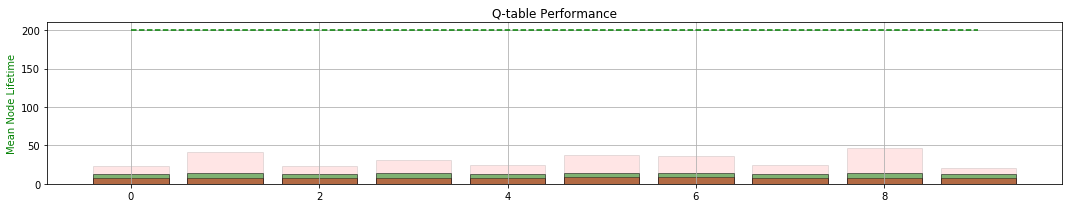

MEMORY COUNTER:  13289
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 663.656	LOSS : 615.312	LOSS : 594.558	LOSS : 611.719	LOSS : 595.406	LOSS : 589.626	LOSS : 562.852	LOSS : 551.121	LOSS : 569.339	LOSS : 547.389	LOSS : 515.704	LOSS : 538.092	LOSS : 526.071	LOSS : 517.580	LOSS : 532.691	LOSS : 528.577	LOSS : 523.411	LOSS : 521.814	LOSS : 518.410	LOSS : 489.464	
Validating... MEAN TIME:  98.665
LOSS : 511.742	LOSS : 494.575	LOSS : 496.592	LOSS : 506.369	LOSS : 490.668	LOSS : 501.625	LOSS : 495.667	LOSS : 490.886	LOSS : 485.721	LOSS : 491.686	LOSS : 484.966	LOSS : 505.103	LOSS : 491.144	LOSS : 489.452	LOSS : 468.343	LOSS : 469.675	LOSS : 480.269	LOSS : 496.870	LOSS : 490.357	LOSS : 470.662	
Validating... MEAN TIME:  125.96
LOSS : 473.013	LOSS : 479.810	LOSS : 458.406	LOSS : 472.115	LOSS : 475.578	LOSS : 458.263	LOSS : 473.958	LOSS : 464.752	LOSS : 469.647	LOSS : 477.068	LOSS : 471.694	LOSS : 478.743	LOSS : 463.812	LOSS : 453.847	LOSS : 463.408	LOSS : 466.358	LOSS : 473

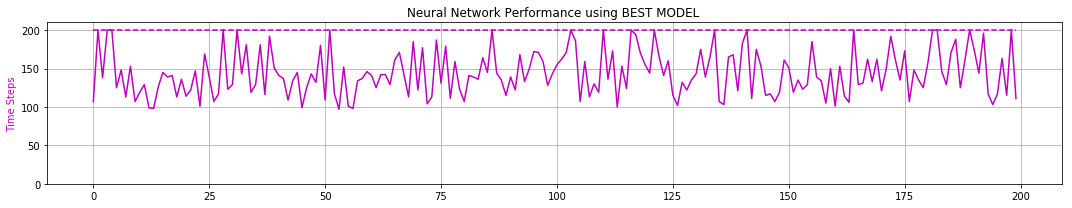

peak memory: 12030.26 MiB, increment: 10680.93 MiB
0 -max- [ 0.205  1.907  0.205  2.708  0.274]
0 -min- [-0.202 -1.774 -0.209 -2.755  0.225]

1 -max- [ 0.301  1.805  0.209  3.268  0.325]
1 -min- [-0.232 -2.673 -0.209 -2.754  0.275]

2 -max- [ 0.206  1.929  0.209  2.760  0.375]
2 -min- [-0.195 -1.780 -0.209 -2.833  0.325]

3 -max- [ 0.235  1.955  0.209  2.747  0.425]
3 -min- [-0.189 -1.963 -0.209 -2.888  0.375]

4 -max- [ 0.218  1.787  0.209  2.900  0.474]
4 -min- [-0.194 -1.971 -0.208 -2.734  0.426]

5 -max- [ 0.437  2.267  0.209  2.938  0.525]
5 -min- [-0.221 -1.962 -0.208 -2.945  0.476]

6 -max- [ 0.366  2.540  0.207  2.502  0.575]
6 -min- [-0.192 -1.598 -0.208 -2.900  0.525]

7 -max- [ 0.222  2.147  0.209  2.748  0.624]
7 -min- [-0.202 -1.806 -0.209 -2.965  0.576]

8 -max- [ 0.437  2.458  0.209  2.924  0.675]
8 -min- [-0.208 -1.921 -0.209 -2.914  0.625]

9 -max- [ 0.194  1.802  0.209  2.788  0.724]
9 -min- [-0.200 -1.792 -0.209 -2.746  0.675]

Quantization TIME:  0.1 minutes


ITERA

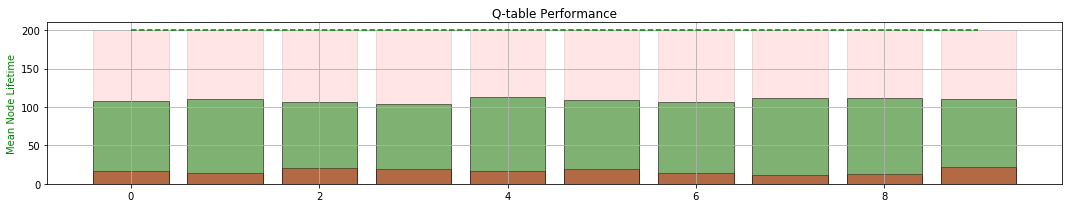

MEMORY COUNTER:  122430
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 320.969	LOSS : 307.138	LOSS : 293.630	LOSS : 281.691	LOSS : 267.835	LOSS : 244.060	LOSS : 226.934	LOSS : 226.396	LOSS : 221.644	LOSS : 222.089	LOSS : 207.128	LOSS : 205.805	LOSS : 197.269	LOSS : 195.053	LOSS : 188.350	LOSS : 176.595	LOSS : 186.391	LOSS : 175.331	LOSS : 171.203	LOSS : 168.921	
Validating... MEAN TIME:  137.96
LOSS : 176.012	LOSS : 171.101	LOSS : 169.809	LOSS : 168.930	LOSS : 163.662	LOSS : 167.713	LOSS : 148.636	LOSS : 156.923	LOSS : 157.675	LOSS : 153.656	LOSS : 151.295	LOSS : 152.415	LOSS : 156.877	LOSS : 151.573	LOSS : 144.773	LOSS : 149.521	LOSS : 143.291	LOSS : 146.048	LOSS : 157.285	LOSS : 156.298	
Validating... MEAN TIME:  161.0
LOSS : 160.257	LOSS : 148.752	LOSS : 154.896	LOSS : 173.452	LOSS : 154.578	LOSS : 152.507	LOSS : 157.300	LOSS : 165.054	LOSS : 167.299	LOSS : 159.769	LOSS : 160.820	LOSS : 157.702	LOSS : 148.124	LOSS : 153.913	LOSS : 167.229	LOSS : 141.664	LOSS : 158

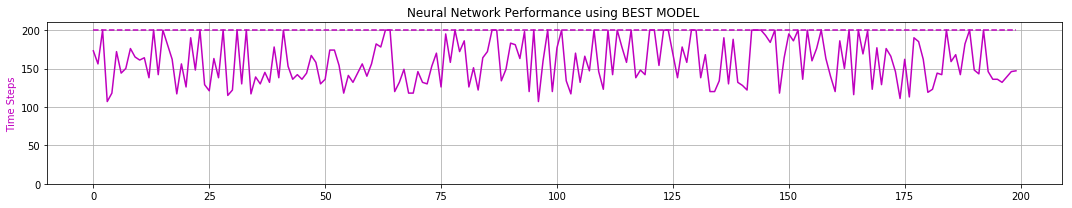

peak memory: 12407.56 MiB, increment: 10823.30 MiB
0 -max- [ 0.847  1.509  0.208  2.202  0.275]
0 -min- [-0.934 -1.925 -0.209 -2.549  0.225]

1 -max- [ 1.179  2.283  0.209  1.932  0.324]
1 -min- [-0.958 -1.909 -0.209 -2.040  0.275]

2 -max- [ 0.901  1.581  0.209  2.262  0.374]
2 -min- [-1.099 -1.936 -0.209 -2.097  0.326]

3 -max- [ 0.988  1.843  0.209  2.240  0.425]
3 -min- [-1.069 -1.794 -0.209 -2.272  0.376]

4 -max- [ 1.071  1.870  0.209  2.539  0.474]
4 -min- [-0.998 -1.785 -0.209 -2.270  0.426]

5 -max- [ 0.982  1.707  0.209  2.053  0.524]
5 -min- [-0.904 -1.841 -0.209 -2.030  0.476]

6 -max- [ 0.816  1.725  0.209  1.871  0.575]
6 -min- [-0.951 -1.871 -0.209 -2.719  0.526]

7 -max- [ 0.908  1.719  0.209  2.021  0.624]
7 -min- [-0.954 -2.085 -0.209 -1.904  0.576]

8 -max- [ 1.106  1.904  0.209  1.903  0.674]
8 -min- [-0.993 -2.040 -0.209 -2.306  0.626]

9 -max- [ 0.888  1.695  0.209  1.967  0.725]
9 -min- [-1.366 -2.207 -0.209 -2.803  0.676]

Quantization TIME:  0.1 minutes


ITERA

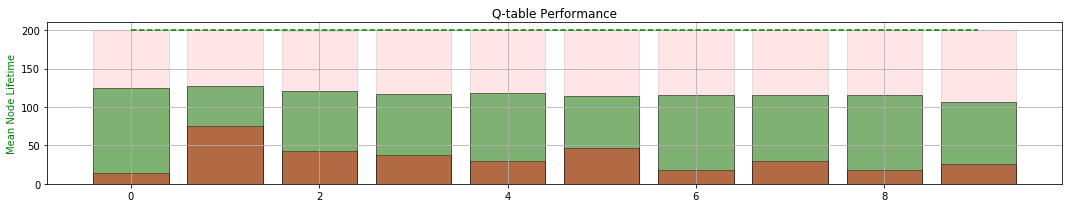

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 90.230	LOSS : 94.580	LOSS : 86.426	LOSS : 88.538	LOSS : 94.857	LOSS : 85.268	LOSS : 86.180	LOSS : 81.868	LOSS : 87.762	LOSS : 81.565	LOSS : 81.703	LOSS : 78.535	LOSS : 88.926	LOSS : 80.966	LOSS : 89.171	LOSS : 77.919	LOSS : 81.760	LOSS : 85.036	LOSS : 90.350	LOSS : 89.082	
Validating... MEAN TIME:  156.415
LOSS : 81.175	LOSS : 87.921	LOSS : 87.183	LOSS : 78.992	LOSS : 70.630	LOSS : 77.641	LOSS : 84.096	LOSS : 69.180	LOSS : 81.552	LOSS : 79.190	LOSS : 80.454	LOSS : 84.369	LOSS : 85.968	LOSS : 82.049	LOSS : 84.544	LOSS : 78.939	LOSS : 82.864	LOSS : 74.008	LOSS : 84.459	LOSS : 84.575	
Validating... MEAN TIME:  138.695
LOSS : 79.487	LOSS : 77.889	LOSS : 92.419	LOSS : 77.097	LOSS : 78.623	LOSS : 82.798	LOSS : 77.145	LOSS : 77.593	LOSS : 84.967	LOSS : 74.894	LOSS : 84.778	LOSS : 82.341	LOSS : 87.321	LOSS : 85.944	LOSS : 85.698	LOSS : 92.728	LOSS : 86.111	LOSS : 81.771	LOSS : 78.164	LOSS : 73.567	
Valida

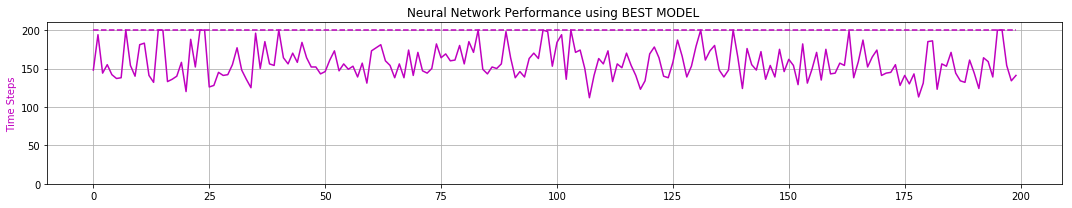

peak memory: 12397.64 MiB, increment: 10780.87 MiB
0 -max- [ 1.585  1.818  0.204  1.671  0.274]
0 -min- [-1.349 -2.003 -0.209 -1.998  0.225]

1 -max- [ 1.695  1.881  0.207  1.627  0.324]
1 -min- [-1.306 -1.997 -0.209 -1.867  0.276]

2 -max- [ 1.833  2.038  0.209  1.622  0.375]
2 -min- [-1.272 -1.893 -0.209 -1.888  0.326]

3 -max- [ 1.508  1.792  0.206  1.635  0.425]
3 -min- [-1.287 -2.015 -0.209 -1.888  0.375]

4 -max- [ 1.755  2.072  0.208  1.881  0.475]
4 -min- [-1.214 -2.074 -0.209 -1.805  0.425]

5 -max- [ 1.729  2.080  0.209  1.868  0.525]
5 -min- [-1.265 -2.058 -0.209 -2.152  0.475]

6 -max- [ 1.638  2.030  0.209  1.719  0.574]
6 -min- [-1.194 -1.905 -0.209 -1.662  0.525]

7 -max- [ 1.701  2.184  0.208  1.817  0.624]
7 -min- [-1.271 -2.041 -0.209 -1.910  0.575]

8 -max- [ 1.678  2.011  0.204  1.781  0.674]
8 -min- [-1.310 -2.033 -0.209 -1.976  0.625]

9 -max- [ 0.851  1.311  0.202  1.858  0.725]
9 -min- [-1.166 -2.052 -0.209 -2.043  0.676]

Quantization TIME:  0.11 minutes


ITER

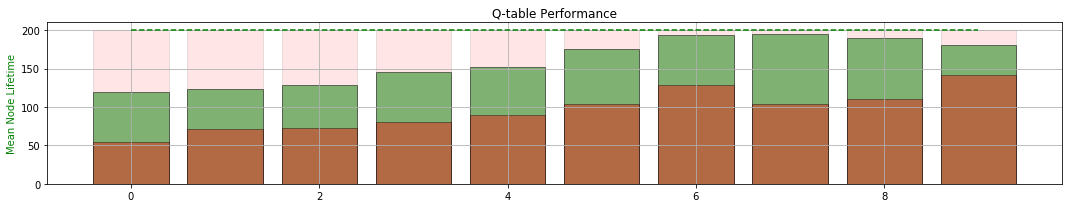

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 76.359	LOSS : 67.107	LOSS : 72.683	LOSS : 65.603	LOSS : 64.796	LOSS : 55.130	LOSS : 67.198	LOSS : 69.234	LOSS : 61.264	LOSS : 62.620	LOSS : 63.906	LOSS : 66.372	LOSS : 58.726	LOSS : 59.806	LOSS : 58.034	LOSS : 57.657	LOSS : 58.587	LOSS : 59.340	LOSS : 57.406	LOSS : 55.546	
Validating... MEAN TIME:  137.17
LOSS : 69.857	LOSS : 63.653	LOSS : 65.544	LOSS : 58.861	LOSS : 64.026	LOSS : 68.431	LOSS : 65.896	LOSS : 52.304	LOSS : 55.458	LOSS : 62.565	LOSS : 70.381	LOSS : 57.610	LOSS : 58.870	LOSS : 66.573	LOSS : 58.323	LOSS : 60.660	LOSS : 62.527	LOSS : 61.345	LOSS : 60.237	LOSS : 59.077	
Validating... MEAN TIME:  153.87
LOSS : 57.754	LOSS : 63.072	LOSS : 63.674	LOSS : 65.419	LOSS : 61.445	LOSS : 60.857	LOSS : 57.027	LOSS : 65.060	LOSS : 64.591	LOSS : 66.487	LOSS : 64.032	LOSS : 71.295	LOSS : 59.781	LOSS : 58.815	LOSS : 54.468	LOSS : 61.435	LOSS : 68.950	LOSS : 59.531	LOSS : 68.574	LOSS : 70.666	
Validati

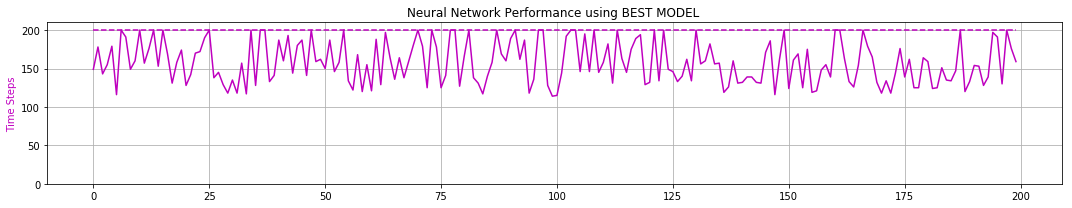

peak memory: 12450.70 MiB, increment: 10799.96 MiB
0 -max- [ 2.391  2.426  0.173  1.595  0.275]
0 -min- [-1.471 -2.253 -0.209 -2.232  0.226]

1 -max- [ 2.384  2.740  0.194  1.613  0.325]
1 -min- [-1.502 -2.205 -0.209 -1.694  0.275]

2 -max- [ 2.362  2.415  0.187  1.598  0.375]
2 -min- [-1.677 -2.388 -0.209 -1.885  0.325]

3 -max- [ 2.394  2.420  0.196  1.632  0.425]
3 -min- [-1.417 -2.211 -0.209 -1.880  0.375]

4 -max- [ 2.391  2.608  0.199  1.805  0.475]
4 -min- [-1.433 -2.124 -0.209 -2.016  0.425]

5 -max- [ 2.395  2.590  0.203  1.631  0.525]
5 -min- [-1.516 -2.220 -0.209 -1.972  0.475]

6 -max- [ 2.366  2.420  0.203  1.924  0.575]
6 -min- [-1.534 -2.092 -0.209 -1.956  0.525]

7 -max- [ 2.394  2.610  0.209  1.820  0.624]
7 -min- [-1.411 -2.032 -0.208 -1.693  0.575]

8 -max- [ 2.397  2.894  0.209  1.789  0.675]
8 -min- [-1.395 -2.063 -0.209 -1.855  0.625]

9 -max- [ 2.396  2.928  0.209  1.630  0.724]
9 -min- [-0.824 -1.392 -0.205 -1.606  0.676]

Quantization TIME:  0.11 minutes


ITER

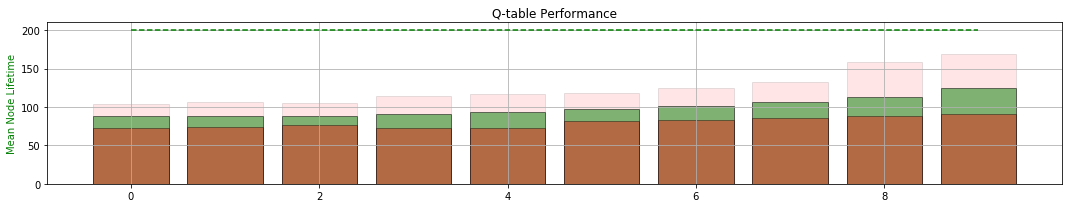

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 77.807	LOSS : 76.923	LOSS : 82.790	LOSS : 82.379	LOSS : 73.449	LOSS : 76.489	LOSS : 68.986	LOSS : 69.253	LOSS : 64.944	LOSS : 72.083	LOSS : 72.885	LOSS : 78.293	LOSS : 77.369	LOSS : 58.588	LOSS : 62.844	LOSS : 65.920	LOSS : 69.419	LOSS : 67.031	LOSS : 70.628	LOSS : 70.698	
Validating... MEAN TIME:  100.685
LOSS : 73.936	LOSS : 73.445	LOSS : 59.477	LOSS : 74.923	LOSS : 67.076	LOSS : 65.714	LOSS : 72.809	LOSS : 62.830	LOSS : 67.190	LOSS : 70.006	LOSS : 73.742	LOSS : 64.877	LOSS : 63.300	LOSS : 67.608	LOSS : 60.546	LOSS : 66.960	LOSS : 69.177	LOSS : 74.290	LOSS : 75.762	LOSS : 71.070	
Validating... MEAN TIME:  115.025
LOSS : 70.137	LOSS : 73.695	LOSS : 76.267	LOSS : 71.645	LOSS : 73.094	LOSS : 81.641	LOSS : 67.793	LOSS : 67.100	LOSS : 65.308	LOSS : 70.143	LOSS : 70.121	LOSS : 74.525	LOSS : 71.713	LOSS : 60.345	LOSS : 65.790	LOSS : 73.030	LOSS : 73.407	LOSS : 64.198	LOSS : 65.723	LOSS : 63.599	
Valida

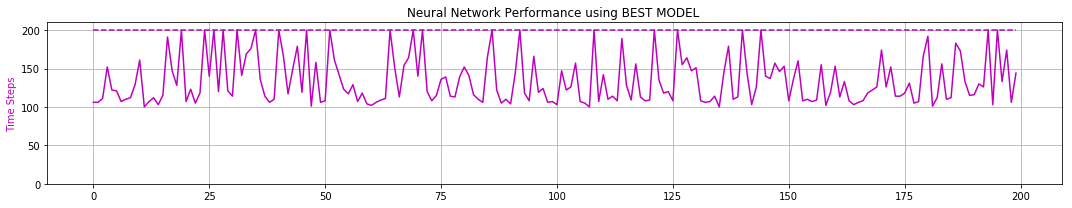

peak memory: 12419.95 MiB, increment: 10783.29 MiB
0 -max- [ 0.162  0.953  0.049  0.836  0.273]
0 -min- [-1.939 -2.609 -0.209 -1.364  0.225]

1 -max- [ 0.140  0.637  0.050  0.888  0.325]
1 -min- [-1.977 -2.760 -0.209 -1.028  0.276]

2 -max- [ 0.141  0.807  0.050  0.814  0.374]
2 -min- [-1.863 -2.378 -0.209 -1.200  0.325]

3 -max- [ 0.163  0.636  0.048  0.940  0.425]
3 -min- [-1.858 -2.318 -0.209 -1.122  0.376]

4 -max- [ 0.158  0.811  0.050  0.877  0.474]
4 -min- [-1.803 -2.253 -0.209 -1.297  0.426]

5 -max- [ 0.141  0.786  0.049  0.879  0.525]
5 -min- [-1.793 -2.173 -0.209 -1.227  0.475]

6 -max- [ 0.138  0.635  0.049  0.878  0.575]
6 -min- [-1.923 -2.376 -0.209 -0.956  0.525]

7 -max- [ 0.128  0.758  0.050  1.122  0.625]
7 -min- [-2.130 -2.532 -0.209 -1.092  0.576]

8 -max- [ 0.159  0.632  0.049  0.909  0.675]
8 -min- [-2.146 -2.548 -0.209 -1.085  0.625]

9 -max- [ 0.149  0.627  0.050  0.926  0.725]
9 -min- [-2.052 -2.411 -0.209 -1.069  0.676]

Quantization TIME:  0.1 minutes


ITERA

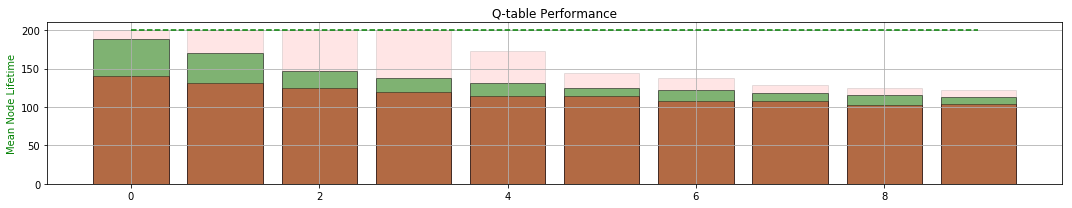

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 87.506	LOSS : 78.183	LOSS : 99.703	LOSS : 82.857	LOSS : 93.785	LOSS : 94.403	LOSS : 92.594	LOSS : 92.232	LOSS : 91.276	LOSS : 77.545	LOSS : 82.971	LOSS : 90.913	LOSS : 93.354	LOSS : 84.141	LOSS : 82.429	LOSS : 85.704	LOSS : 72.165	LOSS : 77.894	LOSS : 78.346	LOSS : 76.933	
Validating... MEAN TIME:  118.35
LOSS : 77.805	LOSS : 80.931	LOSS : 71.113	LOSS : 79.801	LOSS : 78.583	LOSS : 77.830	LOSS : 75.677	LOSS : 72.856	LOSS : 82.365	LOSS : 67.724	LOSS : 80.223	LOSS : 76.908	LOSS : 74.730	LOSS : 74.395	LOSS : 79.771	LOSS : 78.506	LOSS : 69.696	LOSS : 62.001	LOSS : 76.300	LOSS : 73.370	
Validating... MEAN TIME:  149.075
LOSS : 71.507	LOSS : 74.669	LOSS : 73.695	LOSS : 68.956	LOSS : 71.252	LOSS : 73.017	LOSS : 67.188	LOSS : 72.216	LOSS : 63.008	LOSS : 73.587	LOSS : 67.095	LOSS : 70.958	LOSS : 70.003	LOSS : 70.835	LOSS : 67.258	LOSS : 72.682	LOSS : 71.811	LOSS : 71.849	LOSS : 64.157	LOSS : 66.339	
Validat

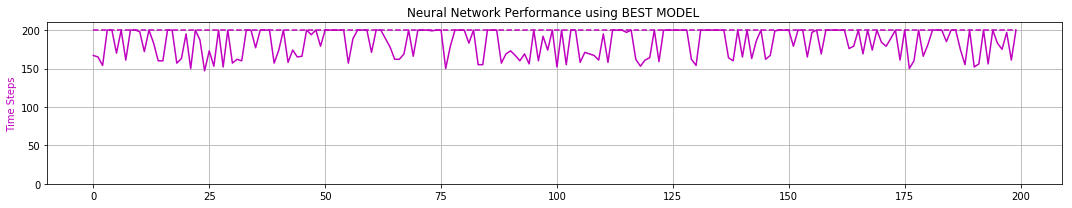

peak memory: 12355.04 MiB, increment: 10687.86 MiB
0 -max- [ 2.399  3.573  0.183  1.648  0.274]
0 -min- [-2.263 -2.564 -0.167 -2.278  0.225]

1 -max- [ 2.400  3.584  0.167  1.799  0.325]
1 -min- [-0.357 -1.723 -0.169 -2.242  0.275]

2 -max- [ 2.399  3.349  0.171  1.601  0.374]
2 -min- [-1.061 -2.214 -0.127 -1.769  0.325]

3 -max- [ 2.400  3.601  0.180  1.464  0.425]
3 -min- [-0.133 -1.011 -0.080 -2.135  0.375]

4 -max- [ 2.400  3.547  0.181  1.601  0.474]
4 -min- [-0.146 -1.181 -0.090 -2.068  0.425]

5 -max- [ 2.400  2.924  0.183  1.615  0.525]
5 -min- [-0.133 -1.018 -0.050 -1.079  0.475]

6 -max- [ 2.400  2.968  0.187  1.294  0.575]
6 -min- [-0.163 -0.825 -0.050 -1.323  0.526]

7 -max- [ 2.399  2.943  0.172  1.399  0.625]
7 -min- [-0.157 -1.018 -0.049 -1.048  0.576]

8 -max- [ 2.398  2.934  0.183  1.450  0.674]
8 -min- [-0.151 -1.021 -0.049 -1.130  0.626]

9 -max- [ 2.399  2.911  0.199  1.488  0.725]
9 -min- [-0.183 -0.986 -0.050 -1.057  0.675]

Quantization TIME:  0.1 minutes


ITERA

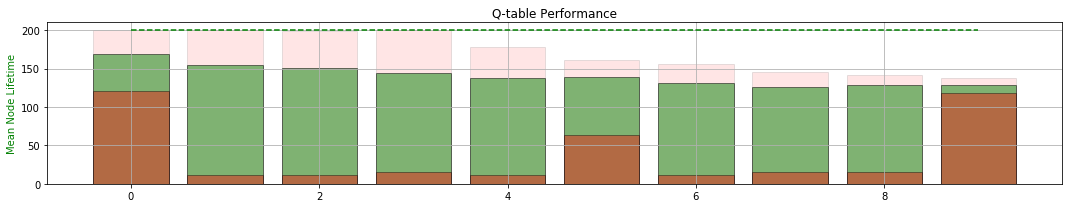

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 66.652	LOSS : 51.594	LOSS : 48.066	LOSS : 61.912	LOSS : 63.278	LOSS : 64.799	LOSS : 67.164	LOSS : 54.474	LOSS : 60.426	LOSS : 68.655	LOSS : 66.482	LOSS : 52.755	LOSS : 53.729	LOSS : 69.413	LOSS : 59.153	LOSS : 63.703	LOSS : 67.656	LOSS : 53.616	LOSS : 58.065	LOSS : 69.422	
Validating... MEAN TIME:  200.0
LOSS : 65.057	LOSS : 60.262	LOSS : 53.698	LOSS : 60.428	LOSS : 56.555	LOSS : 57.714	LOSS : 50.367	LOSS : 61.587	LOSS : 63.246	LOSS : 60.316	LOSS : 52.010	LOSS : 60.896	LOSS : 65.257	LOSS : 55.354	LOSS : 65.651	LOSS : 67.254	LOSS : 56.737	LOSS : 59.771	LOSS : 59.233	LOSS : 56.447	
Validating... MEAN TIME:  111.49
LOSS : 56.838	LOSS : 60.917	LOSS : 58.139	LOSS : 54.121	LOSS : 57.869	LOSS : 64.614	LOSS : 60.705	LOSS : 57.769	LOSS : 56.201	LOSS : 59.957	LOSS : 60.453	LOSS : 59.850	LOSS : 53.874	LOSS : 61.225	LOSS : 55.384	LOSS : 62.421	LOSS : 55.207	LOSS : 59.082	LOSS : 54.670	LOSS : 50.197	
Validatin

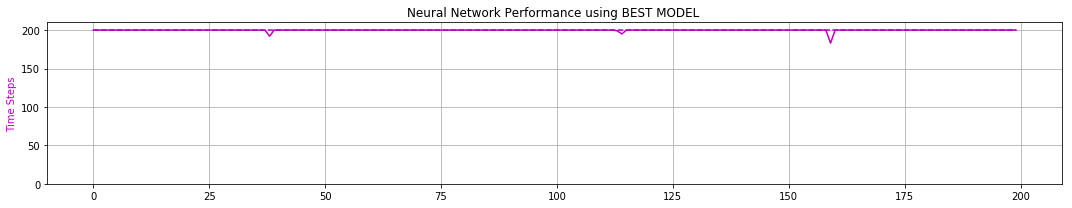

peak memory: 12355.40 MiB, increment: 10699.72 MiB
0 -max- [ 0.163  1.147  0.167  1.911  0.275]
0 -min- [-2.208 -2.457 -0.209 -1.736  0.225]

1 -max- [ 0.192  1.021  0.147  1.943  0.325]
1 -min- [-2.268 -2.498 -0.209 -1.577  0.275]

2 -max- [ 0.187  1.198  0.195  1.936  0.375]
2 -min- [-2.302 -2.305 -0.209 -1.818  0.325]

3 -max- [ 0.202  1.209  0.178  1.882  0.424]
3 -min- [-2.358 -2.597 -0.209 -1.753  0.375]

4 -max- [ 0.174  1.196  0.155  1.797  0.474]
4 -min- [-2.330 -2.428 -0.209 -1.669  0.426]

5 -max- [ 0.177  1.177  0.194  1.975  0.524]
5 -min- [-2.396 -2.591 -0.209 -1.759  0.475]

6 -max- [ 0.204  1.157  0.164  1.913  0.573]
6 -min- [-2.395 -2.607 -0.209 -1.665  0.525]

7 -max- [ 0.181  1.212  0.169  1.991  0.625]
7 -min- [-2.399 -2.796 -0.209 -1.703  0.576]

8 -max- [ 0.175  1.016  0.158  1.955  0.675]
8 -min- [-2.400 -2.657 -0.209 -1.452  0.627]

9 -max- [ 0.159  1.018  0.165  1.914  0.725]
9 -min- [-2.399 -2.832 -0.209 -1.503  0.676]

Quantization TIME:  0.1 minutes


ITERA

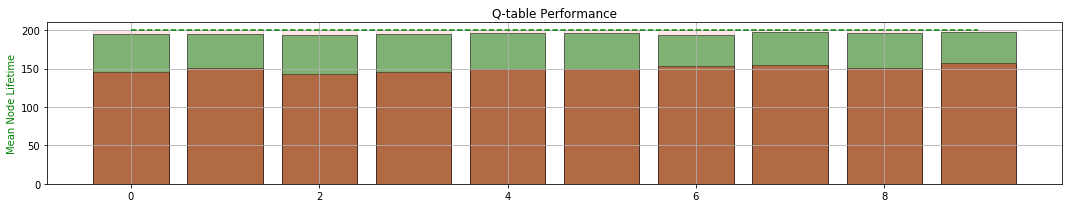

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 58.069	LOSS : 61.499	LOSS : 49.012	LOSS : 55.667	LOSS : 55.282	LOSS : 58.601	LOSS : 49.280	LOSS : 50.543	LOSS : 48.511	LOSS : 46.442	LOSS : 49.610	LOSS : 57.345	LOSS : 50.066	LOSS : 55.213	LOSS : 50.293	LOSS : 58.903	LOSS : 47.231	LOSS : 46.881	LOSS : 48.710	LOSS : 52.560	
Validating... MEAN TIME:  189.005
LOSS : 53.345	LOSS : 50.576	LOSS : 46.596	LOSS : 44.781	LOSS : 54.808	LOSS : 46.901	LOSS : 48.928	LOSS : 51.736	LOSS : 47.048	LOSS : 53.427	LOSS : 51.006	LOSS : 46.728	LOSS : 45.914	LOSS : 52.159	LOSS : 54.311	LOSS : 49.189	LOSS : 51.033	LOSS : 47.546	LOSS : 41.724	LOSS : 53.017	
Validating... MEAN TIME:  118.535
LOSS : 48.181	LOSS : 54.459	LOSS : 45.333	LOSS : 56.397	LOSS : 50.915	LOSS : 57.832	LOSS : 61.216	LOSS : 47.178	LOSS : 43.758	LOSS : 55.620	LOSS : 53.370	LOSS : 53.158	LOSS : 54.586	LOSS : 48.290	LOSS : 43.052	LOSS : 52.392	LOSS : 48.483	LOSS : 62.012	LOSS : 47.736	LOSS : 52.835	
Valida

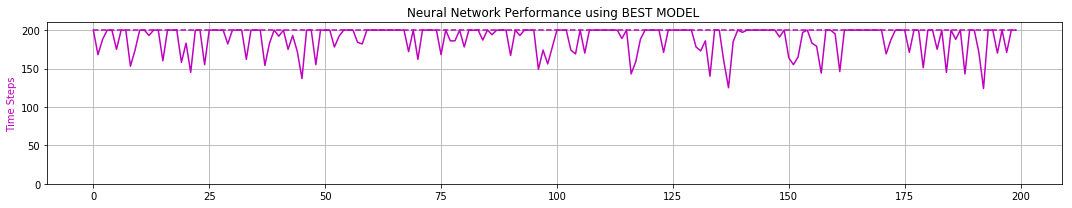

peak memory: 12400.59 MiB, increment: 10719.83 MiB
0 -max- [ 1.603  2.424  0.124  1.848  0.275]
0 -min- [-2.395 -2.573 -0.207 -1.736  0.226]

1 -max- [ 1.400  2.301  0.137  1.677  0.325]
1 -min- [-2.395 -2.406 -0.208 -1.593  0.275]

2 -max- [ 1.563  2.279  0.134  1.611  0.374]
2 -min- [-2.400 -2.381 -0.208 -1.506  0.326]

3 -max- [ 1.359  2.298  0.150  1.779  0.425]
3 -min- [-2.398 -2.568 -0.209 -1.513  0.376]

4 -max- [ 1.860  2.495  0.137  1.472  0.475]
4 -min- [-2.400 -2.250 -0.202 -1.754  0.425]

5 -max- [ 1.636  2.475  0.147  1.635  0.524]
5 -min- [-2.398 -2.354 -0.204 -1.641  0.475]

6 -max- [ 1.767  2.277  0.127  1.332  0.575]
6 -min- [-2.398 -2.380 -0.206 -1.406  0.527]

7 -max- [ 2.178  2.254  0.183  1.301  0.624]
7 -min- [-2.398 -2.188 -0.209 -1.263  0.575]

8 -max- [ 1.802  2.394  0.133  1.658  0.674]
8 -min- [-2.399 -2.159 -0.205 -1.620  0.626]

9 -max- [ 1.680  2.470  0.174  1.484  0.724]
9 -min- [-2.399 -2.378 -0.198 -1.605  0.675]

Quantization TIME:  0.11 minutes


ITER

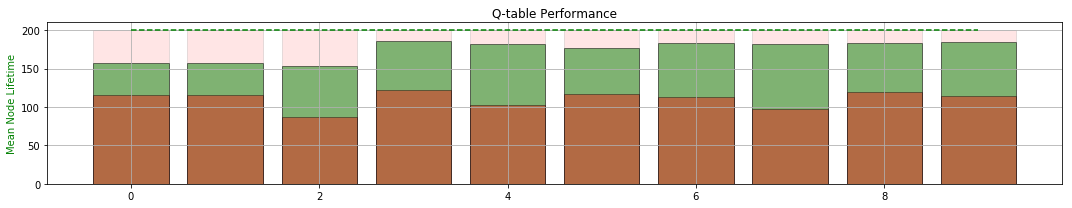

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 69.801	LOSS : 75.882	LOSS : 77.137	LOSS : 61.986	LOSS : 72.858	LOSS : 59.054	LOSS : 59.192	LOSS : 74.678	LOSS : 58.591	LOSS : 58.381	LOSS : 70.181	LOSS : 66.272	LOSS : 64.146	LOSS : 70.871	LOSS : 62.543	LOSS : 54.415	LOSS : 57.851	LOSS : 65.799	LOSS : 59.917	LOSS : 62.324	
Validating... MEAN TIME:  15.45
LOSS : 72.689	LOSS : 62.739	LOSS : 64.530	LOSS : 70.704	LOSS : 62.490	LOSS : 51.647	LOSS : 68.556	LOSS : 69.513	LOSS : 54.127	LOSS : 65.664	LOSS : 65.591	LOSS : 63.039	LOSS : 65.885	LOSS : 59.241	LOSS : 62.193	LOSS : 64.528	LOSS : 66.521	LOSS : 59.402	LOSS : 61.262	LOSS : 58.818	
Validating... MEAN TIME:  10.11
LOSS : 69.799	LOSS : 70.055	LOSS : 63.470	LOSS : 59.258	LOSS : 59.783	LOSS : 64.673	LOSS : 64.796	LOSS : 68.117	LOSS : 56.600	LOSS : 56.803	LOSS : 56.286	LOSS : 62.329	LOSS : 60.353	LOSS : 65.702	LOSS : 65.254	LOSS : 58.706	LOSS : 60.625	LOSS : 57.037	LOSS : 61.651	LOSS : 63.006	
Validating

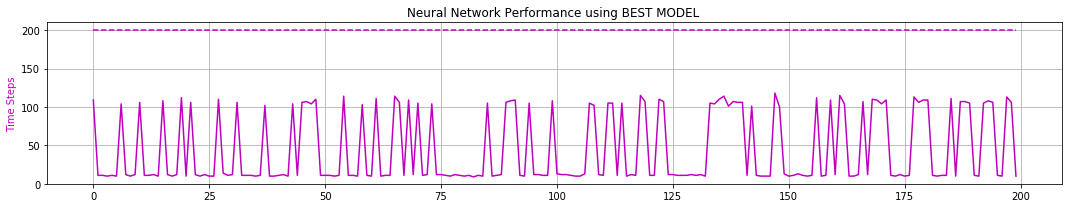

peak memory: 12359.05 MiB, increment: 10666.62 MiB
0 -max- [ 2.353  2.147  0.209  1.053  0.275]
0 -min- [-2.400 -3.143 -0.207 -0.996  0.226]

1 -max- [ 2.006  1.875  0.192  1.069  0.325]
1 -min- [-2.399 -3.293 -0.209 -1.119  0.275]

2 -max- [ 2.393  2.403  0.208  0.827  0.375]
2 -min- [-2.400 -3.121 -0.209 -0.926  0.325]

3 -max- [ 2.304  2.179  0.206  1.100  0.423]
3 -min- [-2.398 -3.469 -0.209 -1.063  0.375]

4 -max- [ 2.059  1.862  0.200  0.998  0.475]
4 -min- [-2.400 -3.129 -0.209 -1.070  0.425]

5 -max- [ 2.356  2.417  0.205  1.009  0.525]
5 -min- [-2.400 -3.259 -0.207 -1.051  0.475]

6 -max- [ 2.161  2.028  0.208  0.949  0.575]
6 -min- [-2.400 -3.472 -0.208 -1.018  0.527]

7 -max- [ 2.122  1.873  0.201  0.941  0.625]
7 -min- [-2.398 -3.260 -0.209 -1.095  0.576]

8 -max- [ 2.066  1.861  0.203  0.922  0.674]
8 -min- [-2.399 -3.162 -0.209 -0.994  0.625]

9 -max- [ 2.175  1.868  0.209  1.017  0.725]
9 -min- [-2.399 -3.463 -0.209 -1.042  0.677]

Quantization TIME:  0.1 minutes


ITERA

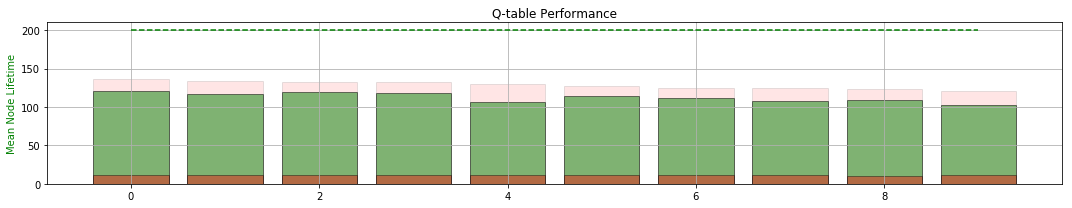

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 84.896	LOSS : 80.603	LOSS : 76.061	LOSS : 85.533	LOSS : 84.916	LOSS : 71.132	LOSS : 83.772	LOSS : 82.094	LOSS : 70.360	LOSS : 93.000	LOSS : 81.553	LOSS : 80.131	LOSS : 86.254	LOSS : 88.624	LOSS : 76.196	LOSS : 82.908	LOSS : 78.279	LOSS : 74.639	LOSS : 86.129	LOSS : 82.284	
Validating... MEAN TIME:  198.045
LOSS : 77.723	LOSS : 74.368	LOSS : 80.815	LOSS : 72.772	LOSS : 79.636	LOSS : 79.454	LOSS : 76.633	LOSS : 85.758	LOSS : 82.003	LOSS : 77.615	LOSS : 70.141	LOSS : 83.298	LOSS : 89.635	LOSS : 76.443	LOSS : 75.204	LOSS : 76.209	LOSS : 78.985	LOSS : 80.481	LOSS : 87.203	LOSS : 87.838	
Validating... MEAN TIME:  109.52
LOSS : 66.589	LOSS : 83.942	LOSS : 77.045	LOSS : 76.636	LOSS : 73.081	LOSS : 75.455	LOSS : 78.237	LOSS : 70.055	LOSS : 68.461	LOSS : 73.667	LOSS : 75.804	LOSS : 75.627	LOSS : 71.925	LOSS : 73.465	LOSS : 74.449	LOSS : 77.095	LOSS : 76.283	LOSS : 69.674	LOSS : 68.856	LOSS : 69.365	
Validat

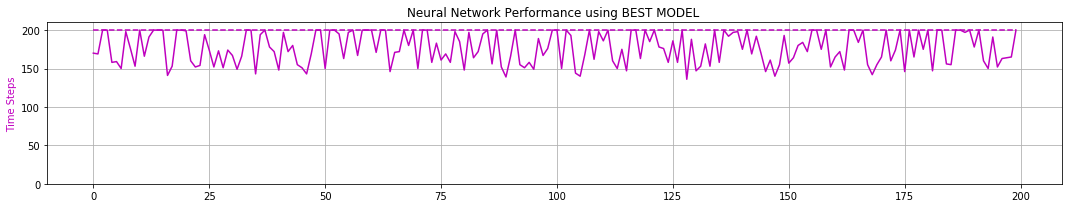

peak memory: 12369.86 MiB, increment: 10677.04 MiB
0 -max- [ 2.400  2.938  0.204  2.304  0.275]
0 -min- [-0.181 -1.579 -0.049 -1.384  0.225]

1 -max- [ 2.400  2.787  0.208  1.986  0.325]
1 -min- [-0.192 -1.396 -0.054 -1.169  0.275]

2 -max- [ 2.400  2.388  0.209  1.969  0.374]
2 -min- [-0.233 -1.394 -0.050 -1.073  0.327]

3 -max- [ 2.400  2.741  0.206  1.979  0.425]
3 -min- [-0.187 -1.377 -0.049 -1.287  0.375]

4 -max- [ 2.400  2.422  0.207  1.997  0.475]
4 -min- [-0.200 -1.411 -0.049 -1.263  0.425]

5 -max- [ 2.400  2.416  0.204  2.071  0.524]
5 -min- [-0.225 -1.401 -0.050 -1.272  0.476]

6 -max- [ 2.400  2.805  0.207  1.992  0.575]
6 -min- [-0.191 -1.377 -0.049 -1.207  0.525]

7 -max- [ 2.400  2.581  0.209  1.998  0.625]
7 -min- [-0.176 -1.397 -0.050 -1.302  0.575]

8 -max- [ 2.399  2.434  0.209  1.835  0.675]
8 -min- [-0.200 -1.216 -0.046 -1.049  0.625]

9 -max- [ 2.399  2.585  0.209  2.274  0.725]
9 -min- [-0.189 -1.607 -0.049 -1.075  0.675]

Quantization TIME:  0.1 minutes


ITERA

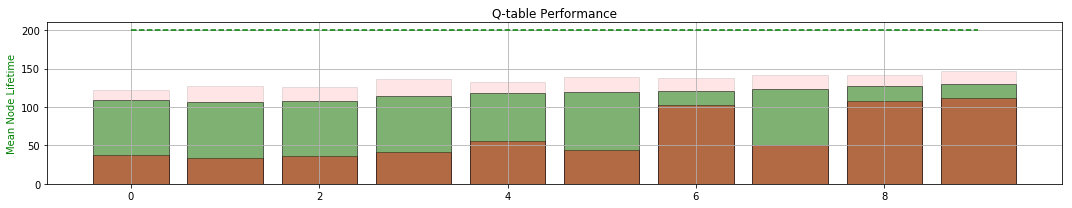

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 83.478	LOSS : 99.944	LOSS : 106.371	LOSS : 94.656	LOSS : 84.266	LOSS : 109.305	LOSS : 88.879	LOSS : 116.204	LOSS : 91.456	LOSS : 104.933	LOSS : 96.332	LOSS : 108.249	LOSS : 100.020	LOSS : 90.640	LOSS : 88.296	LOSS : 95.941	LOSS : 87.756	LOSS : 92.822	LOSS : 103.482	LOSS : 107.367	
Validating... MEAN TIME:  162.64
LOSS : 94.753	LOSS : 93.402	LOSS : 110.011	LOSS : 101.024	LOSS : 114.128	LOSS : 105.595	LOSS : 93.639	LOSS : 98.594	LOSS : 95.122	LOSS : 103.841	LOSS : 104.416	LOSS : 91.757	LOSS : 82.711	LOSS : 99.376	LOSS : 94.878	LOSS : 94.912	LOSS : 97.536	LOSS : 91.636	LOSS : 83.080	LOSS : 85.247	
Validating... MEAN TIME:  181.26
LOSS : 92.313	LOSS : 102.222	LOSS : 86.350	LOSS : 82.639	LOSS : 81.732	LOSS : 82.167	LOSS : 77.077	LOSS : 74.640	LOSS : 94.550	LOSS : 86.322	LOSS : 82.843	LOSS : 88.770	LOSS : 90.838	LOSS : 82.677	LOSS : 83.275	LOSS : 89.373	LOSS : 86.947	LOSS : 99.959	LOSS : 87.148	LOSS : 7

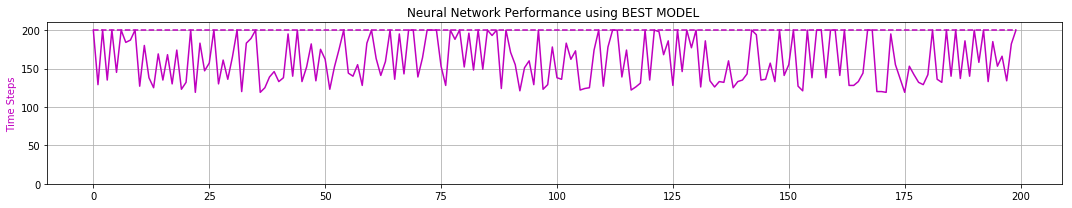

peak memory: 12583.07 MiB, increment: 10889.76 MiB
0 -max- [ 0.136  0.592  0.049  0.686  0.275]
0 -min- [-2.398 -3.111 -0.208 -1.083  0.225]

1 -max- [ 0.136  0.604  0.050  0.843  0.325]
1 -min- [-2.399 -2.971 -0.209 -1.234  0.277]

2 -max- [ 0.166  0.619  0.049  0.933  0.374]
2 -min- [-2.399 -3.103 -0.209 -1.135  0.326]

3 -max- [ 0.158  0.446  0.050  0.881  0.423]
3 -min- [-2.400 -2.937 -0.209 -1.177  0.375]

4 -max- [ 0.153  0.439  0.049  0.692  0.475]
4 -min- [-2.399 -2.940 -0.207 -1.279  0.426]

5 -max- [ 0.151  0.769  0.053  0.743  0.525]
5 -min- [-2.400 -2.899 -0.209 -1.270  0.476]

6 -max- [ 0.123  0.631  0.049  0.687  0.575]
6 -min- [-2.400 -2.776 -0.207 -1.221  0.525]

7 -max- [ 0.152  0.598  0.050  0.691  0.625]
7 -min- [-2.400 -2.612 -0.209 -1.093  0.576]

8 -max- [ 0.144  0.567  0.051  0.749  0.675]
8 -min- [-2.400 -2.608 -0.207 -1.245  0.626]

9 -max- [ 0.137  0.546  0.050  0.882  0.725]
9 -min- [-2.400 -2.624 -0.208 -1.472  0.675]

Quantization TIME:  0.1 minutes


ITERA

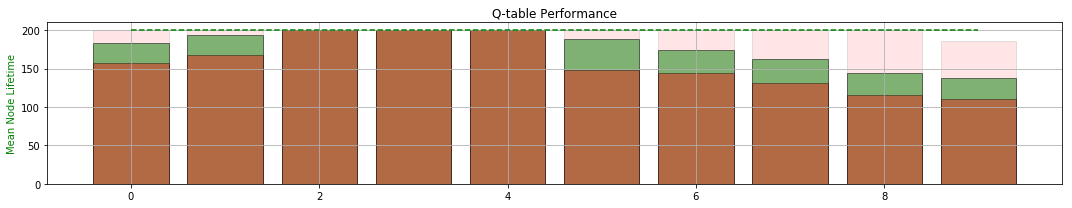

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 64.391	LOSS : 64.350	LOSS : 66.155	LOSS : 67.459	LOSS : 58.475	LOSS : 56.917	LOSS : 60.589	LOSS : 72.342	LOSS : 60.847	LOSS : 71.079	LOSS : 66.804	LOSS : 63.977	LOSS : 59.691	LOSS : 66.842	LOSS : 59.125	LOSS : 65.636	LOSS : 67.070	LOSS : 57.447	LOSS : 64.088	LOSS : 57.962	
Validating... MEAN TIME:  121.43
LOSS : 63.714	LOSS : 51.868	LOSS : 62.995	LOSS : 61.997	LOSS : 55.551	LOSS : 65.358	LOSS : 60.742	LOSS : 64.721	LOSS : 60.052	LOSS : 66.388	LOSS : 67.953	LOSS : 54.579	LOSS : 60.231	LOSS : 49.215	LOSS : 51.636	LOSS : 70.623	LOSS : 66.827	LOSS : 68.590	LOSS : 66.785	LOSS : 54.978	
Validating... MEAN TIME:  74.995
LOSS : 55.449	LOSS : 60.637	LOSS : 59.871	LOSS : 67.199	LOSS : 63.612	LOSS : 68.706	LOSS : 59.227	LOSS : 52.297	LOSS : 66.088	LOSS : 57.000	LOSS : 63.899	LOSS : 58.969	LOSS : 50.875	LOSS : 62.655	LOSS : 50.728	LOSS : 57.133	LOSS : 51.579	LOSS : 54.793	LOSS : 58.476	LOSS : 63.767	
Validati

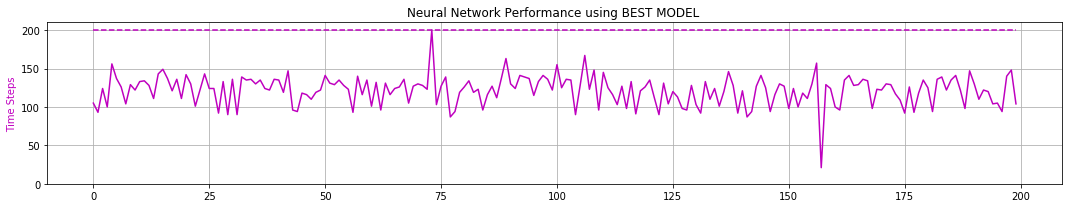

peak memory: 12402.27 MiB, increment: 10741.50 MiB
0 -max- [ 2.400  2.186  0.157  1.313  0.275]
0 -min- [-0.255 -0.617 -0.071 -1.242  0.225]

1 -max- [ 2.400  2.217  0.176  1.651  0.325]
1 -min- [-0.191 -0.625 -0.120 -1.602  0.276]

2 -max- [ 2.173  1.682  0.120  1.247  0.375]
2 -min- [-0.256 -0.617 -0.092 -1.255  0.325]

3 -max- [ 0.842  0.998  0.078  1.287  0.425]
3 -min- [-0.773 -0.619 -0.092 -0.964  0.375]

4 -max- [ 0.442  0.618  0.060  0.712  0.474]
4 -min- [-1.573 -1.515 -0.196 -1.072  0.426]

5 -max- [ 0.159  0.613  0.070  0.953  0.525]
5 -min- [-2.381 -2.362 -0.209 -1.030  0.475]

6 -max- [ 0.204  0.430  0.058  0.952  0.574]
6 -min- [-2.400 -2.420 -0.209 -1.024  0.525]

7 -max- [ 0.263  0.428  0.052  0.674  0.625]
7 -min- [-2.400 -2.428 -0.209 -1.073  0.575]

8 -max- [ 0.207  0.603  0.050  0.707  0.674]
8 -min- [-2.400 -2.590 -0.209 -1.089  0.626]

9 -max- [ 0.206  0.627  0.049  0.687  0.724]
9 -min- [-2.400 -2.572 -0.208 -1.051  0.675]

Quantization TIME:  0.11 minutes


ITER

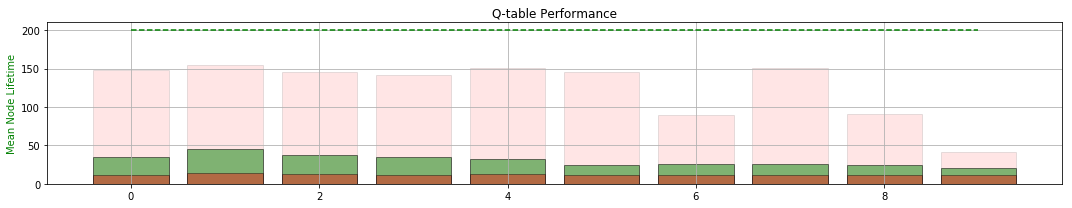

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 102.648	LOSS : 92.877	LOSS : 93.147	LOSS : 89.860	LOSS : 89.420	LOSS : 83.774	LOSS : 86.606	LOSS : 92.782	LOSS : 89.361	LOSS : 85.518	LOSS : 100.178	LOSS : 97.443	LOSS : 105.221	LOSS : 87.550	LOSS : 96.314	LOSS : 106.688	LOSS : 104.038	LOSS : 92.955	LOSS : 102.297	LOSS : 102.503	
Validating... MEAN TIME:  114.32
LOSS : 91.292	LOSS : 95.729	LOSS : 88.746	LOSS : 96.281	LOSS : 99.137	LOSS : 91.791	LOSS : 96.803	LOSS : 89.476	LOSS : 99.215	LOSS : 96.382	LOSS : 104.500	LOSS : 100.122	LOSS : 85.888	LOSS : 92.520	LOSS : 104.748	LOSS : 94.631	LOSS : 90.906	LOSS : 96.896	LOSS : 97.200	LOSS : 88.233	
Validating... MEAN TIME:  111.715
LOSS : 100.140	LOSS : 91.236	LOSS : 91.666	LOSS : 98.147	LOSS : 84.333	LOSS : 103.331	LOSS : 96.965	LOSS : 89.660	LOSS : 91.293	LOSS : 98.422	LOSS : 86.953	LOSS : 89.159	LOSS : 92.012	LOSS : 94.528	LOSS : 89.173	LOSS : 92.340	LOSS : 88.879	LOSS : 81.999	LOSS : 77.778	LOSS : 91.

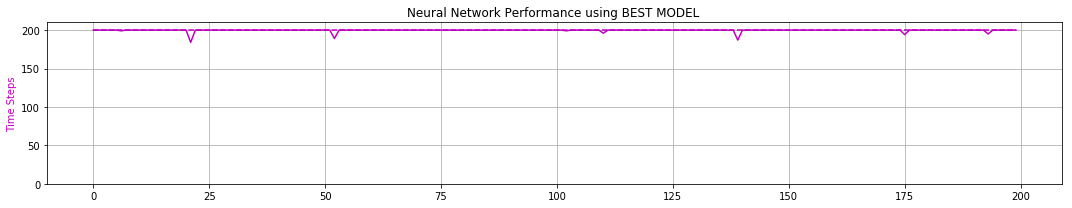

peak memory: 12488.61 MiB, increment: 10862.27 MiB
0 -max- [ 2.230  2.320  0.208  2.007  0.274]
0 -min- [-0.140 -1.377 -0.209 -2.061  0.225]

1 -max- [ 2.290  2.120  0.209  2.292  0.325]
1 -min- [-0.145 -2.080 -0.209 -1.667  0.275]

2 -max- [ 2.209  1.936  0.208  2.222  0.375]
2 -min- [-2.368 -2.823 -0.209 -1.653  0.325]

3 -max- [ 2.344  2.027  0.208  2.000  0.425]
3 -min- [-1.317 -2.763 -0.209 -1.672  0.375]

4 -max- [ 2.246  2.231  0.209  2.096  0.475]
4 -min- [-0.117 -1.545 -0.209 -1.903  0.425]

5 -max- [ 2.272  2.240  0.204  2.162  0.525]
5 -min- [-0.085 -1.909 -0.209 -1.804  0.475]

6 -max- [ 0.749  2.225  0.209  2.152  0.574]
6 -min- [-0.097 -1.874 -0.209 -1.916  0.525]

7 -max- [ 2.391  2.078  0.207  2.173  0.625]
7 -min- [-0.607 -2.450 -0.209 -1.728  0.575]

8 -max- [ 0.281  1.203  0.049  0.378  0.675]
8 -min- [-0.396 -1.608 -0.209 -1.661  0.625]

9 -max- [ 0.205  0.835  0.049  0.376  0.724]
9 -min- [-0.048 -0.925 -0.209 -1.324  0.675]

Quantization TIME:  0.1 minutes


ITERA

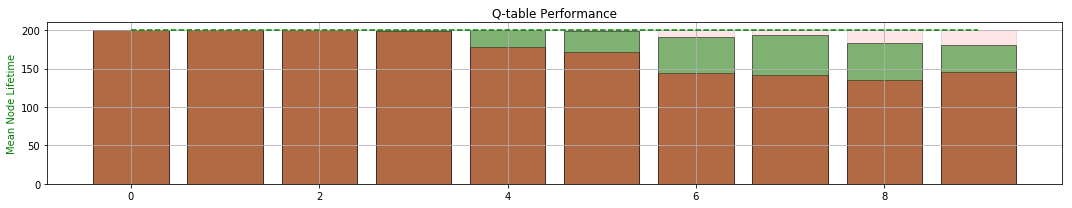

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2453.0
Total Serial Timesteps   :  1780704.0
Speed-up                 :  725.93


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9086 SUCCESS 135  13    2453    1780704     725.93
